In [527]:
# import the used libraries
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import scipy
from scipy.optimize import minimize
from scipy.ndimage import shift

import bspline
import bspline.splinelab as splinelab
import time
import pandas as pd
import cvxpy as cp
import QuantLib as ql
import scipy
import sys
from tqdm import tqdm

glob = dict()

# Model Calibration #

In [528]:
def swapRates(tau, p, mat):

        tmax = mat[-1]

        ttemp = np.arange(1/12, tmax + 1/12, 1/12)
        ptemp = np.interp(ttemp, tau, p)

        dis = np.cumsum(ptemp)
        #dis = dis(:);

        # linear interpolation
        pmat = np.interp(mat, tau, p)

        index = (2 * mat).astype(int) - 1
        S = 100 * 2 * (1 - pmat) / dis[index]
        return S


def liborRates(tau, p, mat):
    pmat = np.interp(mat, tau, p)
    L = 100 * (1. / pmat - 1) / mat
    return L

def calibration_report(swaptions, vols_data):
    
    columns = ["Model Price", "Market Price", "Implied Vol", "Market Vol", "Rel Er\
    ror Price", "Rel Error Vols", "Expiry", "Maturity"]
    
    report_data = []
    cum_err = 0.0
    cum_err2 = 0.0
    
    for i, s in enumerate(swaptions):
        model_price = s.modelValue()
        market_vol = vols_data[i]['vol']
        black_price = s.blackPrice(market_vol)
        rel_error = model_price/black_price - 1.0
        implied_vol = s.impliedVolatility(model_price,
        1e-1, 50, 0, 1.00)
     
        rel_error2 = implied_vol/market_vol-1.0
        cum_err += rel_error*rel_error
        cum_err2 += rel_error2*rel_error2
        report_data.append((model_price, black_price, implied_vol, market_vol, rel_error, rel_error2, vols_data[i]['expiry'], vols_data[i]['maturity']))
        
    print("Cumulative Error Price: %7.5f" % math.sqrt(cum_err))
    print("Cumulative Error Vols : %7.5f" % math.sqrt(cum_err2))
    
    return pd.DataFrame(report_data,columns= columns, index=['']*len(report_data))

def cost_function_generator(model, helpers, norm=False):
    def cost_function(params):
        params_ = ql.Array(list(params));
        model.setParams(params_)
        error = [h.calibrationError() for h in helpers];
        if norm:
            return np.sqrt(np.sum(np.abs(error)))
        else:
            return error
    return cost_function

In [529]:
## Term Structure Model ##
class TS:
    def __init__(self, calibration_path, vols_path, payment_periods, tstart, num_paths, notional):
        self.discountBoundPaths = None
        self.num_paths = num_paths
        self.term_structure = self.build_curve(calibration_path, tstart);
        self.calibrated_model, gauss_generator = self.calibrate(vols_path, notional, payment_periods)
        _, self.short_rate_paths = self.generate_paths(num_paths, gauss_generator)
        #plt.plot(self.short_rate_paths.T)
        
    def generate_paths(self, num_paths, seq):
        timestep = 5400
        arr = np.zeros((num_paths, timestep+1))
        for i in range(num_paths):
            sample_path = seq.next()
            path = sample_path.value()
            time = [path.time(j) for j in range(len(path))]
            value = [path[j] for j in range(len(path))]
            arr[i, :] = np.array(value)
        return np.array(time), arr   
    
    def build_curve(self, calibration_path, tstart):
        df = pd.read_csv(calibration_path)
        data = []
        for i in range(len(df)):
            dt = dict(df.loc[i])
            dt['Date'] = '2023-06-30 00:00:00'
            data.append(dt)

        calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
        zeros = []
        deposits = ['1M', '3M', '6M', '12M']
        swaps = ['2Y', '3Y', '5Y', '7Y', '10Y', '15Y', '20Y', '30Y']
        for row in data[tstart:tstart+1]:
          
            # Build Curve for the date
            curve_date = ql.Date(row['Date'][:10], '%Y-%m-%d')
            ql.Settings.instance().evaluationDate = curve_date
            spot_date = calendar.advance(curve_date, 0, ql.Days) # beginning of eval - 2 days forward
            helpers = ql.RateHelperVector()
            for tenor in deposits:
                index = ql.USDLibor(ql.Period(tenor))
                helpers.append(
                    ql.DepositRateHelper(row[tenor] / 100, index)
                )
            for tenor in swaps:
                swap_index = ql.UsdLiborSwapIsdaFixAm(ql.Period(tenor))
                helpers.append(
                    ql.SwapRateHelper(row[tenor] / 100, swap_index)
                )
            curve = ql.PiecewiseCubicZero(curve_date, helpers, ql.Actual360())
        curve.enableExtrapolation()
        term_structure = ql.YieldTermStructureHandle(curve)
        return term_structure

    def calibrate(self, vols_path, notional, payment_periods):
      
        timestep = 5400
        model = ql.HullWhite(self.term_structure);
        engine = ql.JamshidianSwaptionEngine(model)

        index = ql.Euribor6M(self.term_structure)
        fixedLegTenor = ql.Period(payment_periods, ql.Months) # originally 1Y
        fixedLegDayCounter = ql.Actual360()
        floatingLegDayCounter = ql.Actual360()

        ## Grab volatilities ##
        df  = pd.read_csv(vols_path)
        date1 = df.loc[tstart] # Index important here
        volcub = np.reshape(date1[1:].values, (7,2))
        tenor_labels = [_ for _ in [5, 10]]
        expiry_labels = [_ for _ in [1/12, 3/12, 6/12, 1, 2, 5, 10]]
        self.swaption_vols = pd.DataFrame(volcub, index=expiry_labels, columns=tenor_labels)
        swaptions = []
        ql.Settings.instance().evaluationDate = ql.Date(30, 6, 2023)
        vols_data = []
   
        cnt = 0
        for maturity in self.swaption_vols.index:
            for tenor in self.swaption_vols.columns:
                vol = self.swaption_vols.at[maturity, tenor] / 100
                if(vol != 0):
                        vols_data.append({'vol':vol, 'expiry':maturity, 'maturity':tenor})
                        volatility = ql.QuoteHandle(ql.SimpleQuote(vol))
                        helper = ql.SwaptionHelper(
                            ql.Period(int(maturity*12), ql.Months),
                            ql.Period(int(tenor), ql.Years),
                            volatility,
                            index,
                            fixedLegTenor,
                            fixedLegDayCounter,
                            floatingLegDayCounter,
                            self.term_structure,
                            ql.BlackCalibrationHelper.RelativePriceError,
                            ql.nullDouble(),
                            notional, # nominal
                            ql.ShiftedLognormal, # ShiftedLogn
                            0.00 #shift to make rates non-negative
                        )
                        helper.setPricingEngine(engine)
                        swaptions.append(helper)
                        glob[(maturity, tenor)] = [cnt, vol];
                        cnt += 1;
                    
                else:
                    raise ValueError("0 vol. provied!")
    

        optimization_method = ql.LevenbergMarquardt(1.0e-8,1.0e-8,1.0e-8)
        end_criteria = ql.EndCriteria(500000, 1000, 1e-6, 1e-8, 1e-8)
        model.calibrate(swaptions, optimization_method, end_criteria)
        
        self.params = model.params()
        
        df = calibration_report(swaptions, vols_data)
        #display(df)
        
        sigma = self.params[1]
        a = self.params[0]
        length = 15 # in years
        day_count = ql.Thirty360(ql.Thirty360.BondBasis)
        todays_date =  ql.Date(30, 6, 2023)

        ql.Settings.instance().evaluationDate = todays_date

        hw_process = ql.HullWhiteProcess(self.term_structure, a, sigma)
        
        rng = ql.GaussianLowDiscrepancySequenceGenerator(ql.UniformLowDiscrepancySequenceGenerator(timestep))
        seq = ql.GaussianSobolPathGenerator(hw_process, length, timestep, rng, False)

        #rng = ql.GaussianRandomSequenceGenerator(ql.UniformRandomSequenceGenerator(timestep, ql.UniformRandomGenerator()))
        #seq = ql.GaussianPathGenerator(hw_process, length, timestep, rng, False)
        
        self.swaptions = swaptions;
            
        return model, seq
    
    def ZCBCurve(self, t, k=None, sched=None):
        """ P(t, T) for all t, T """
        if(sched is None):
            raise ValueError("Payment schedule not provided!")
        sched = sched/360
        def discountBond(T, k):
            r = self.short_rate_paths[k,int(t*360)]
            return self.calibrated_model.discountBond(t, T, r)
        
        if(k is not None):
            path = self.short_rate_paths[k, :];
            PTt = [self.calibrated_model.discountBond(t, i+t, path[int(t*360)]) for i in sched] #path[int(t*12)]
            return PTt;

        ts = sched + t
        ks = np.arange(self.num_paths)
        T, K = np.meshgrid(ts, ks)
        PTts = np.fromiter(map(discountBond, T.ravel(), K.ravel()), T.dtype).reshape(T.shape)
        self.discountBondPaths = PTts
        num_traj, traj_length = PTts.shape
        PTtsAvg = np.mean(PTts, axis=0)
        
        return PTtsAvg

# Swaption, Swap Structure and Terms #

In [665]:
class swap:
    def __init__(self, forward_time, maturity, fixed_sched, floating_sched, fixed_rate, tau_n, notional, tsobject, tstart, N_MC=100):

        self.forward_time = forward_time;
        self.maturity = maturity;
        self.fixed_sched = fixed_sched;
        self.floating_sched = floating_sched;
        self.fixed_rate = fixed_rate;
        self.tau_n = tau_n;
        self.notional = notional
        
        num_paths = N_MC
        #tstart = 0
        self.tsh = tsobject
        
        self.term_structure = self.advance_dynamics(0)
        if(fixed_rate is None):
            A = sum([self.term_structure[i] for i in range(len(self.term_structure)-1)])
            B = sum([self.term_structure[i+1] for i in range(len(self.term_structure)-1)])
            self.fixed_rate = (A-B)/(self.tau_n*B)
        else:
            self.fixed_rate = fixed_rate
        #print("Value at zero = ", self.value_at_t(0))
        #plt.figure(1)
        #plt.plot(tau, self.term_structure)
        #print("params = ", term.par)

    def advance_dynamics(self, t, k=None):
        sched = self.fixed_sched + (self.forward_time - t)*360
        p = self.tsh.ZCBCurve(t, k, sched);
        return p

    def value_at_t(self, t, k=None):

        # calibrate to current time t #
        term_structure = self.advance_dynamics(t, k)
        v_swap = 0;
        annuity = sum(term_structure)*self.tau_n 
        for i in range(0, len(term_structure)-1):
            v_swap += (term_structure[i] - term_structure[i+1] - self.tau_n*self.fixed_rate*term_structure[i+1])
        if(k is not None):
            indx = int((23*t)/self.forward_time)
        return v_swap*self.notional#, v_swap/annuity + self.fixed_rate # (swap value, swap rate)
    
    def payoff(self):
        return max(self.value_at_t(self.forward_time), 0)

# Generate Swap Value Trajectories #

In [666]:
# define swaption class #
class swaption(swap):
    def __init__(self, forward_time, maturity, fixed_rate, notional, tau_n, payment_periods, tstart, N_MC):
        fixed_sched = np.arange(0, maturity*360 + payment_periods, payment_periods)
        floating_sched = fixed_sched;
        tau_n = tau_n
        swap.__init__(self, forward_time, maturity, fixed_sched, floating_sched, fixed_rate, tau_n, notional, tstart, N_MC)
        self.expiry = self.forward_time;
        self.notional = notional
        self.underlying_maturity = maturity

    def payoff(self):
        pay = 0;
        pay += self.value_at_t(self.expiry)
        return pay

T =  23
Cumulative Error Price: 0.14872
Cumulative Error Vols : 0.13916
Time to build Term Structure objct = 31.400752544403076 seconds
Naive payment schedule =  [   0   90  180  270  360  450  540  630  720  810  900  990 1080 1170
 1260 1350 1440 1530 1620 1710 1800 1890]
Completed meshgrid computation in 10.521613359451294 seconds


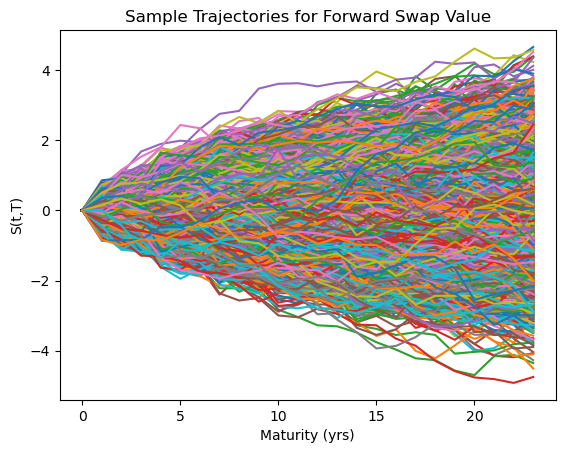

Avg. Numeraire =  0.9956716883208255
Model Estimate =  0.5468115114144017
Monte Carlo Estimate =  0.5095142744324814
Rel. error (to Model est) = -6.82 %


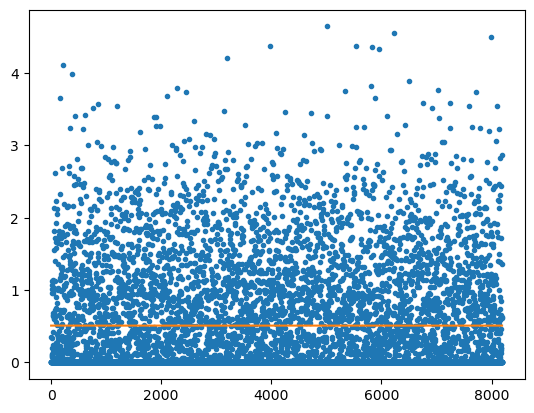

In [678]:
# Get underlying trajectories (treat as stock equity) #    
def run_sim(forward_time, maturity, fixed_rate, N_MC, notional, tsobject, tau_n, payment_periods, tstart):
    fixed_sched = np.arange(0, maturity*360 + 2*payment_periods, payment_periods)
    print("Naive payment schedule = ", fixed_sched)
    floating_sched = fixed_sched;
    tau_n = tau_n
    s1 = swap(forward_time, maturity, fixed_sched, floating_sched, fixed_rate, tau_n, notional, tsobject, tstart, N_MC)
    trajectories = []
    rates = []
    plt.figure(1)
    xs = np.linspace(0, forward_time, 24)
    ys = np.arange(0, N_MC)
    X, Y = np.meshgrid(xs, ys)

    starttime = time.time()
    trajectories = np.fromiter(map(s1.value_at_t, X.ravel(), Y.ravel()), X.dtype).reshape(X.shape)
    plt.plot(trajectories.T)
    print("Completed meshgrid computation in " + str(time.time() - starttime) + " seconds")
    
    plt.xlabel('Maturity (yrs)')
    plt.ylabel("S(t,T)")
    plt.title("Sample Trajectories for Forward Swap Value")
    plt.show()

    return trajectories, rates, s1

forward_time = 1/12 # years
maturity = 5
fixed_rate = None # does not really matter
N_MC = 8192
notional = 100
payment_periods = 3; 
payment_periods *= 30
tau_n = payment_periods/360
T = 24 - 1
print("T = ", T)
tstart = 0;

calibration_path = 'bloomberg_calibration.csv'
vols_path = 'vols_liquid.csv'
start = time.time()
tsobject = TS(calibration_path, vols_path, payment_periods, tstart, N_MC, notional)
print("Time to build Term Structure objct = " + str(time.time() - start) + " seconds")

trajectories, rates, s1 = run_sim(forward_time, maturity, fixed_rate, N_MC, notional, tsobject, tau_n, payment_periods, tstart)

risk_lambda = 0.001 # risk aversion 0.001
K = 0         # option stike
r = 0.03 # risk-free-rate
# Note that we set coef=0 below in function function_B_vec. This correspond to a pure risk-based hedging

expiry = forward_time;
underlying_maturity = maturity;
# Define swaption on underlying, return payoff #
#so = swaption(expiry, underlying_maturity, fixed_rate, notional, tau_n, payment_periods, tstart, N_MC)


## Get swaption index ##
tenor_labels = [_ for _ in [2, 5, 10]]
expiry_labels = [_ for _ in [1/12, 3/12, 6/12, 1, 2, 5, 10]]
row = expiry_labels.index(expiry);
col = tenor_labels.index(underlying_maturity)
meta = glob[(forward_time, maturity)]; ind = meta[0]; vol = meta[1]
##

## Validate monte carlo estimate with analytical
muv  = np.maximum(np.array(trajectories)[:, -1], 0)

dF = np.exp(-np.sum(np.array(s1.tsh.short_rate_paths[:, 0:int(forward_time*360)]), axis=1)*1/360)
print("Avg. Numeraire = ", np.average(dF))
mcest = np.average(np.multiply(muv, dF))
trt = s1.tsh.swaptions[ind].modelValue()

plt.figure(2)
plt.plot(np.multiply(muv, dF), '.')
plt.plot([mcest]*N_MC)

print("Model Estimate = ", trt)
print("Monte Carlo Estimate = ", mcest)
print("Rel. error (to Model est) = %.2f" % (100*(mcest/trt - 1)) + " %")


# QLBS w/ European Swations #

In [679]:
S = np.array(trajectories
)
delta_t = forward_time/T # same as tau_n
gamma = np.exp(- r * delta_t)  # discount factor
delta_S = pd.DataFrame(S[:,1:int(T)+1]- np.exp(r * delta_t) * S[:,0:int(T)])
delta_S_hat = delta_S.apply(lambda x: x - np.mean(x), axis=0)
S = pd.DataFrame(S)

C:\ProgramData\Anaconda3\envs\bermuda_qlbs\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
C:\ProgramData\Anaconda3\envs\bermuda_qlbs\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


X.shape =  (8192, 24)
X_min, X_max =  -4.921808087423269 4.665301328883542
Number of points k =  17


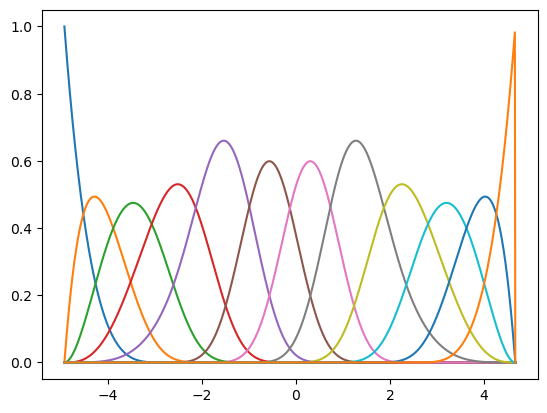

In [680]:
X = S
X_min = np.min(np.min(X))
X_max = np.max(np.max(X))
print('X.shape = ', X.shape)
print('X_min, X_max = ', X_min, X_max)

p = 4              # order of spline (as-is; 3 = cubic, 4: B-spline?) 4, 12
ncolloc = 12

tau = np.linspace(X_min,X_max,ncolloc)  # These are the sites to which we would like to interpolate
# k is a knot vector that adds endpoints repeats as appropriate for a spline of order p
# To get meaninful results, one should have ncolloc >= p+1
k = splinelab.aptknt(tau, p)
# Spline basis of order p on knots k
basis = bspline.Bspline(k, p)

f = plt.figure()
# B   = bspline.Bspline(k, p)     # Spline basis functions
print('Number of points k = ', len(k))
basis.plot()

In [681]:
num_t_steps = int(T)+1
num_basis =  ncolloc # len(k) #

data_mat_t = np.zeros((num_t_steps, N_MC,num_basis ))
print('num_basis = ', num_basis)
print('dim data_mat_t = ', data_mat_t.shape)
                                                                  
t_0 = time.time()
# fill it
for i in np.arange(num_t_steps):
    x = X.values[:,i]
    data_mat_t[i,:,:] = np.array([ basis(el) for el in x ])

t_end = time.time()
print('Computational time:', t_end - t_0, 'seconds')

num_basis =  12
dim data_mat_t =  (24, 8192, 12)
Computational time: 20.288681507110596 seconds


In [690]:
# functions to compute optimal hedges
def function_A_vec(t, delta_S_hat, data_mat, reg_param):
    """
    function_A_vec - compute the matrix A_{nm} from Eq. (52) (with a regularization!)
    Eq. (52) in QLBS Q-Learner in the Black-Scholes-Merton article

    Arguments:
    t - time index, a scalar, an index into time axis of data_mat
    delta_S_hat - pandas.DataFrame of dimension N_MC x T
    data_mat - pandas.DataFrame of dimension T x N_MC x num_basis
    reg_param - a scalar, regularization parameter

    Return:
    - np.array, i.e. matrix A_{nm} of dimension num_basis x num_basis
    """

    X_mat = data_mat[t, :, :]
    num_basis_funcs = X_mat.shape[1]

    this_dS = delta_S_hat.loc[:, t]
    hat_dS2 = np.array((this_dS ** 2)).reshape(-1, 1)
    A_mat = np.dot(X_mat.T, X_mat * hat_dS2) + reg_param * np.eye(num_basis_funcs)
    return A_mat


def function_B_vec(t,
                   Pi_hat,
                   delta_S_hat=delta_S_hat,
                   S=S,
                   data_mat=data_mat_t,
                   gamma=gamma,
                   risk_lambda=risk_lambda,
                   delta_S = None):
    """
    function_B_vec - compute vector B_{n} from Eq. (52) QLBS Q-Learner in the Black-Scholes-Merton article

    Arguments:
    t - time index, a scalar, an index into time axis of delta_S_hat
    Pi_hat - pandas.DataFrame of dimension N_MC x T of portfolio values
    delta_S_hat - pandas.DataFrame of dimension N_MC x T
    S - pandas.DataFrame of simulated stock prices of dimension N_MC x T
    data_mat - pandas.DataFrame of dimension T x N_MC x num_basis
    gamma - one time-step discount factor $exp(-r \delta t)$
    risk_lambda - risk aversion coefficient, a small positive number
    Return:
    np.array() of dimension num_basis x 1
    """
    if(delta_S is None):
        delta_S = pd.DataFrame(np.zeros_like(delta_S_hat))
    coef = 0#1.0/(2 * gamma * risk_lambda)
    # override it by zero to have pure risk hedge

    tmp = Pi_hat.loc[:,t+1].values * delta_S_hat.loc[:, t].values  + coef*delta_S.loc[:, t].values
    X_mat = data_mat[t, :, :]  # matrix of dimension N_MC x num_basis
    B_vec = np.dot(X_mat.T, tmp)

    return B_vec

Computational time: 0.21794915199279785 seconds


c:\temp\1\ipykernel_12836\710416620.py:47: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  net = np.array(Pi - (np.multiply(a, S) ))


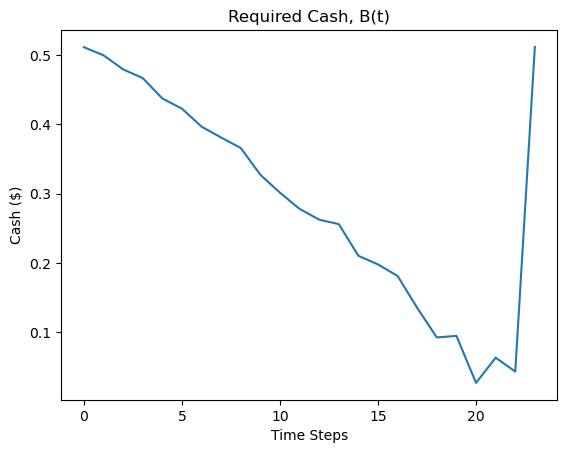

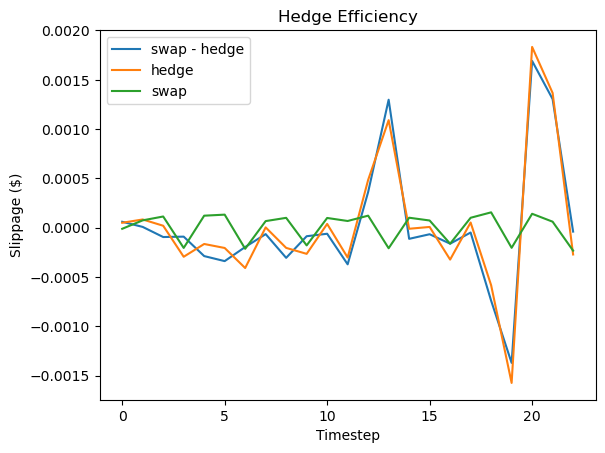

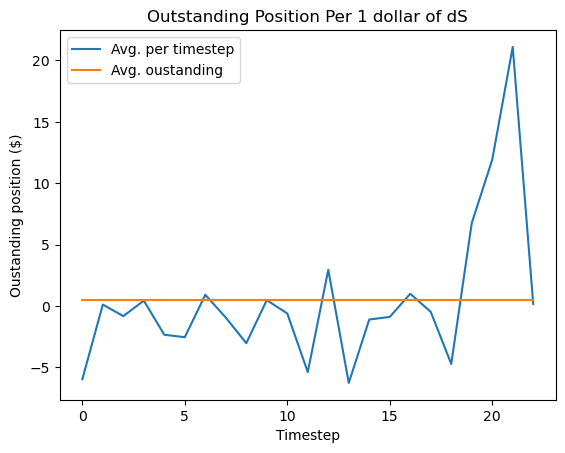

Total unprotected position per timestep = $0.0
Total unprotected position = $0.0
Unprotected position per dollar in dS = $0.47


In [691]:
starttime = time.time()

def terminal_payoff(K, x): #so
    # ST   final stock price
    # K    strike - not used
    #print('x = ' + str(x) + ' | payoff = ' + str(so.payoff()))
    payoff = max(x, 0) #(so.fixed_rate - K > 0)*-so.payoff() #max(K-x,0)#
    return payoff

# portfolio value
Pi = pd.DataFrame([], index=range(1, N_MC+1), columns=range(int(T)+1))
Pi[Pi.columns[-1]] = S[S.columns[-1]].apply(lambda x: terminal_payoff(K, x)).values

Pi = Pi.replace(np.nan, 0)
Pi_hat = pd.DataFrame([], index=range(1, N_MC+1), columns=range(int(T)+1))
Pi_hat[Pi_hat.columns[-1]] = Pi[Pi.columns[-1]]  - np.mean(Pi.iloc[:,-1])

Pi_hat = Pi_hat.replace(np.nan, 0)

# optimal hedge
a = pd.DataFrame([], index=range(1, N_MC+1), columns=range(int(T)+1))
a = a.replace(np.nan, 0)
a.iloc[:,-1] = 0


for t in range(int(T)-1, -1, -1):
 

    A_mat = function_A_vec(t, delta_S_hat, data_mat_t, reg_param) # OG
    B_vec = function_B_vec(t, Pi_hat, delta_S_hat, S, data_mat_t, gamma, risk_lambda, delta_S) # OG delta_S
    
    phi, _ = scipy.sparse.linalg.cg(A_mat, B_vec) #np.dot(np.linalg.inv(A_mat), B_vec) # OG
    tentative =  np.dot(data_mat_t[t,:,:],phi)
    #if(np.linalg.norm(tentative, np.inf) > notional/100):
    #    tentative = a[a.columns[t+1]]
    a[a.columns[t]] = tentative # OG
    Pi[Pi.columns[t]] = gamma * (Pi.loc[:,t+1].values - a.loc[:,t].values * delta_S.loc[:,t].values) # OG
    Pi_hat[Pi_hat.columns[t]] = Pi.loc[:,t].values - np.mean(Pi.loc[:,t]) # 0G
    

a = a.astype('float')
Pi = Pi.astype('float')
Pi_hat = Pi_hat.astype('float')

endtime = time.time()
print('Computational time:', endtime - starttime, 'seconds')
net = np.array(Pi - (np.multiply(a, S) ))
net = np.average(net, axis=0)
plt.figure(1)
plt.plot(net.T)
plt.xlabel('Time Steps')
plt.ylabel("Cash ($)")
plt.title('Required Cash, B(t)')
plt.show()

plt.figure(2)
plt.title("Hedge Efficiency")
plt.xlabel("Timestep")
plt.ylabel("Slippage ($)")
sP = np.diff(np.array(S)); W = np.diff(np.array(Pi));
avgTrue = np.average(sP, axis=0)

tracking = np.average(W-sP, axis=0)
perf = round(np.sum(np.abs(tracking))/T, 2)
str_perf = "Total unprotected position per timestep = $" + str(perf)
str_perf_total = "Total unprotected position = $" + str(round(perf*T, 2))
str_per = "Unprotected position per dollar in dS = $" + str(round(np.average(tracking/avgTrue), 2))

plt.plot(tracking, label='swap - hedge')
plt.plot(np.average(W, axis=0), label='hedge')
plt.plot(np.average(sP, axis=0), label='swap')
plt.legend()

plt.figure(3)
plt.plot(tracking/avgTrue, label='Avg. per timestep')
plt.plot([np.average(tracking/avgTrue)]*len(tracking), label='Avg. oustanding')
plt.title("Outstanding Position Per 1 dollar of dS")
plt.xlabel("Timestep")
plt.legend()
plt.ylabel("Oustanding position ($)")
plt.show()

print(str_perf)
print(str_perf_total)
print(str_per)


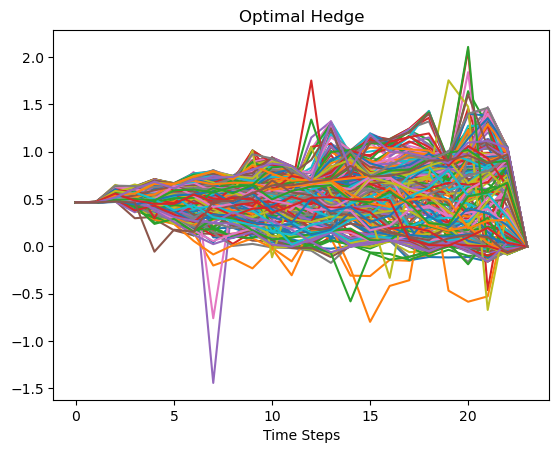

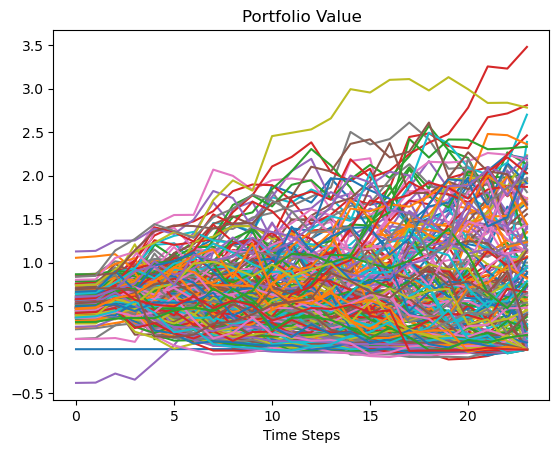

In [692]:
# plot 10 paths
step_size = 32
idx_plot = np.arange(0, N_MC, step_size)
plt.plot(a.T.iloc[:,idx_plot])
plt.xlabel('Time Steps')
plt.title('Optimal Hedge')
plt.show()

plt.plot(Pi.T.iloc[:,idx_plot])
plt.xlabel('Time Steps')
plt.title('Portfolio Value')
plt.show()

c:\temp\1\ipykernel_12836\2445713638.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  R.iloc[:, t] = gamma * a.loc[1:,t].values * delta_S.loc[:,t].values - risk_lambda * np.std(vals.values) /np.mean(vals.values)



Time Cost: 0.043192148208618164 seconds


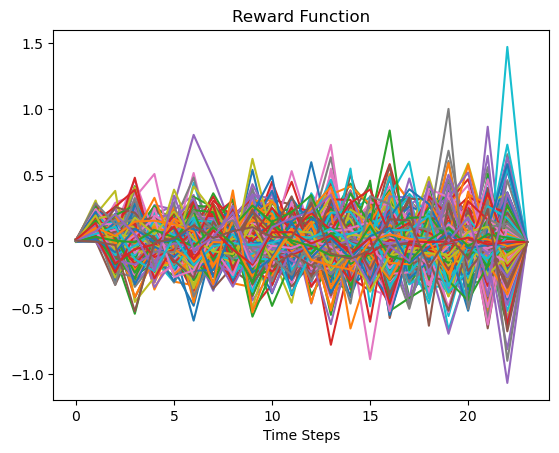

In [693]:
#Compute rewards for all paths
starttime = time.time()
# reward function
R = pd.DataFrame([], index=range(1, N_MC+1), columns=range(int(T)+1))
R[R.columns[-1]] = -risk_lambda * np.std(Pi.iloc[:,-1].values) /np.mean(Pi.iloc[:,-1].values)
for t in range(int(T)):
    vals = Pi.loc[1:, t].replace(np.nan, 0)
    R.iloc[:, t] = gamma * a.loc[1:,t].values * delta_S.loc[:,t].values - risk_lambda * np.std(vals.values) /np.mean(vals.values)

endtime = time.time()
print('\nTime Cost:', endtime - starttime, 'seconds')

# plot 10 paths
plt.plot(R.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.title('Reward Function')
plt.show()

In [694]:
def function_C_vec(t, data_mat, reg_param):
    """
    function_C_vec - calculate C_{nm} matrix from Eq. (56) (with a regularization!)
    Eq. (56) in QLBS Q-Learner in the Black-Scholes-Merton article

    Arguments:
    t - time index, a scalar, an index into time axis of data_mat
    data_mat - pandas.DataFrame of values of basis functions of dimension T x N_MC x num_basis
    reg_param - regularization parameter, a scalar

    Return:
    C_mat - np.array of dimension num_basis x num_basis
    """
    X_mat = data_mat[t, :, :]
    num_basis_funcs = X_mat.shape[1]
    C_mat = np.dot(X_mat.T, X_mat) + reg_param * np.eye(num_basis_funcs)
    return C_mat

def function_D_vec(t, Q, R, data_mat, gamma=gamma):
    """
    function_D_vec - calculate D_{nm} vector from Eq. (56) (with a regularization!)
    Eq. (56) in QLBS Q-Learner in the Black-Scholes-Merton article

    Arguments:
    t - time index, a scalar, an index into time axis of data_mat
    Q - pandas.DataFrame of Q-function values of dimension N_MC x T
    R - pandas.DataFrame of rewards of dimension N_MC x T
    data_mat - pandas.DataFrame of values of basis functions of dimension T x N_MC x num_basis
    gamma - one time-step discount factor $exp(-r \delta t)$

    Return:
    D_vec - np.array of dimension num_basis x 1
    """

    X_mat = data_mat[t, :, :]
    D_vec = np.dot(X_mat.T, R.loc[:,t] + gamma * Q.loc[:, t+1])

    return D_vec


Time Cost: 0.041582584381103516 seconds


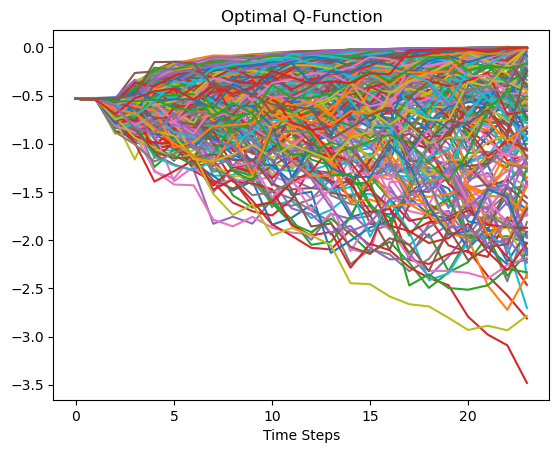

In [695]:
starttime = time.time()
# Q function
Q = pd.DataFrame([], index=range(1, N_MC+1), columns=range(int(T)+1))
Q[Q.columns[-1]] = - Pi[Pi.columns[-1]] - risk_lambda * np.std(Pi.iloc[:,-1])/np.mean(Pi.iloc[:,-1])
reg_param = 1e-3

for t in range(int(T)-1, -1, -1):
    
    C_mat = function_C_vec(t,data_mat_t,reg_param)
    D_vec = function_D_vec(t, Q,R,data_mat_t,gamma)
    omega = np.dot(np.linalg.inv(C_mat), D_vec)

    Q[Q.columns[t]] = np.dot(data_mat_t[t,:,:], omega)

Q = Q.astype('float')

endtime = time.time()
print('\nTime Cost:', endtime - starttime, 'seconds')

# plot 10 paths
plt.plot(Q.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.title('Optimal Q-Function')
plt.show()

In [696]:
# QLBS option price
C_QLBS = - Q.copy()
qp = C_QLBS.iloc[0,0]
bp = s1.tsh.swaptions[ind].blackPrice(s1.tsh.swaption_vols.at[expiry, underlying_maturity]/100) #
mp = s1.tsh.swaptions[ind].modelValue() #
print('-------------------------------------------')
print('       QLBS Option Pricing (DP solution)      ')
print('-------------------------------------------\n')
print('%-25s' % ('Notional:'), notional)
print('%-25s' % ('Expiry of option (yrs)'), expiry)
print('%-25s' % ('Maturity of underlying (yrs):'), underlying_maturity)
print('Tenor (payment) structure  every %d ' % (payment_periods) + '(days)')
print('%-25s' % ('Risk-free rate: '), r)
print('%-25s' % ('Risk aversion parameter: '), risk_lambda)
print('%-25s' % ('Strike:'), K)
print('%-25s' % ('Fixed rate:'), s1.fixed_rate)
print('%-25s' % ('# Trajectories:'), N_MC)
print('%-26s %.4f' % ('\nQLBS Put Price: ', qp))
print('%-26s %.4f' % ('Black Put Price: ', bp))
print('%-26s %.4f' % ('Model Put Price: ', mp)) 
print('%-26s %.4f' % ('\nRel. error (to black): ', 100*(qp/bp - 1)) + " %")
print('%-26s %.4f' % ('Rel. error (to model): ', 100*(qp/mp - 1)) + " %")
print('%-26s %.4f' % ('Rel. error (model to black): ', 100*(mp/bp - 1)) + " %")

-------------------------------------------
       QLBS Option Pricing (DP solution)      
-------------------------------------------

Notional:                 100
Expiry of option (yrs)    0.08333333333333333
Maturity of underlying (yrs): 5
Tenor (payment) structure  every 90 (days)
Risk-free rate:           0.03
Risk aversion parameter:  0.001
Strike:                   0
Fixed rate:               0.031452110359768116
# Trajectories:           8192

QLBS Put Price:           0.5335
Black Put Price:           0.5742
Model Put Price:           0.5468

Rel. error (to black):    -7.0971 %
Rel. error (to model):     -2.4404 %
Rel. error (model to black):  -4.7731 %


In [645]:
 # set swap at inception (today) to zero value
# 